In [1]:
from __future__ import print_function

import argparse
import os
import shutil
import time

import sys
sys.path.append("/ws/external")

# from models.cifar.allconv import AllConvNet
import numpy as np
from third_party.ResNeXt_DenseNet.models.densenet import densenet
from third_party.ResNeXt_DenseNet.models.resnext import resnext29
from third_party.WideResNet_pytorch.wideresnet import WideResNet
from third_party.WideResNet_pytorch.wideresnetproj import WideResNetProj
from third_party.WideResNet_pytorch.wideresnet_encoder import WideResNetEncoder
from third_party.supervised_contrastive_net import SupConNet
from models import MyDataParallel

import torch
import torch.backends.cudnn as cudnn
from torchvision import datasets
from torchvision import transforms
import torch.nn.functional as F

from datasets import *
from losses import CenterLoss, MlpJSDLoss, SupConLoss
from datasets.mixdataset import BaseDataset, AugMixDataset
from feature_hook import FeatureHook
from utils import WandbLogger
# from apis import test, test_c, test_c_dg, Trainer

In [2]:
class Args():
    def __init__(self):
        self.dataset = 'cifar10'
        self.num_classes=10
        
        self.aug = 'augmix'
        self.model = 'wrn'
        self.epochs = 5
        self.batch_size = 8
        self.eval_batch_size = 1000
        
        self.no_jsd = False
        self.additional_loss = 'jsd'
        self.temper = 1.0
        self.lambda_weight = 12.0
                
        # '/ws/data/log/cifar10/augmix_b512/checkpoint.pth.tar' # None '/ws/data/log/cifar10/augmix_b512/checkpoint.pth.tar'
        self.resume = None # '/ws/data/log/cifar10/baselines/augmix_b512/checkpoint.pth.tar' # '/ws/data/log/cifar10/baseline_b512/checkpoint.pth.tar'
        self.evaluate = False
        self.analysis = True
        self.confusion_matrix = False
        self.save = '/ws/data/log/cifar10/augmix_b512' # None
        
        self.learning_rate = 0.001
        self.momentum = 0.9
        self.decay = 0.0005
        self.layers = 40
        self.widen_factor = 2
        self.droprate = 0.0
        self.mixture_width = 3
        self.mixture_depth = -1
        self.aug_severity = 3
        self.mixture_coefficient = 1.0
        
        self.reduction = 'batchmean'
        self.all_ops = 'all'
        self.num_workers = 4
        self.wandb_logger = None
        self.wandb = False
        


In [3]:
args = Args()

In [4]:
''' Load datasets '''
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4)])
preprocess = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5] * 3, [0.5] * 3)])
test_transform = preprocess

train_data = datasets.CIFAR10(
            '/ws/data/cifar', train=True, transform=train_transform, download=True)
test_data = datasets.CIFAR10(
    '/ws/data/cifar', train=False, transform=test_transform, download=True)
base_c_path = '/ws/data/cifar/CIFAR-10-C/'

train_data = AugMixDataset(train_data, preprocess, args.no_jsd,
                           args.all_ops, args.mixture_width, args.mixture_depth, args.aug_severity, args.mixture_coefficient)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=args.eval_batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
net = WideResNet(args.layers, args.num_classes, args.widen_factor, args.droprate)
net = MyDataParallel(net).cuda()
cudnn.benchmark = True
optimizer = torch.optim.SGD(
    net.parameters(),
    args.learning_rate,
    momentum=args.momentum,
    weight_decay=args.decay,
    nesterov=True)

if args.resume:
    if os.path.isfile(args.resume):
        checkpoint = torch.load(args.resume)
        start_epoch = checkpoint['epoch'] + 1
        best_acc = checkpoint['best_acc']
        net.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print('Model restored from epoch:', start_epoch)

In [6]:
net.train()
wandb_features = {}
total_ce_loss = 0.
total_additional_loss = 0.
total_correct = 0.
loss_ema = 0.

In [7]:
images, targets = next(iter(train_loader))
device = targets.device
targets

tensor([8, 8, 9, 2, 9, 1, 7, 3])

In [8]:
optimizer.zero_grad()
images_all = torch.cat(images, 0).cuda()
targets = targets.cuda()

logits_all = net(images_all)
    
logits_clean, logits_aug1, logits_aug2 = torch.split(logits_all, images[0].size(0))

pred_clean = logits_clean.data.max(1)[1]
pred_aug1 = logits_aug1.data.max(1)[1]
correct = pred_clean.eq(targets.data).sum().item()

In [9]:
def get_same_instance(targets):
    device = targets.device
    batch_size = targets.size()[0]
    mask = torch.eye(batch_size, dtype=torch.float32).to(device)
    return mask

def get_same_class(targets):
    targets = targets.contiguous().view(-1, 1)
    mask = torch.eq(targets, targets.T).float()

    return mask

def get_diff_class(targets):
    targets = targets.contiguous().view(-1, 1)
    mask = torch.eq(targets, targets.T).float()
    mask = 1 - mask
    return mask

# def get_true_false_instance(logits_clean, logits_aug1, logits_aug2, targets):
#     device = logits_clean.device
#     batch_size = logits_clean.size()[0]
    
#     pred_clean = logits_clean.data.max(1)[1]
#     pred_aug1 = logits_aug1.data.max(1)[1]
#     pred_aug2 = logits_aug2.data.max(1)[1]
    
#     pred_true = torch.eq(pred_clean, targets).float()
#     pred_true = pred_true.contiguous().view(-1, 1)

        
#     aug1_true = torch.eq(pred_aug1, targets).float()
#     aug1_false = 1 - aug1_true
#     aug1_false = aug1_false.contiguous().view(-1, 1)
    
#     aug2_true = torch.eq(pred_aug2, targets).float()
#     aug2_false = 1 - aug2_true
#     aug2_false = aug2_false.contiguous().view(-1, 1)

    
#     mask_1 = torch.matmul(pred_true, aug1_false.T)
#     mask_2 = torch.matmul(pred_true, aug2_false.T)
    
#     return mask_1
    

In [10]:
device = logits_clean.device
pred_clean = logits_clean.data.max(1)[1]
pred_aug1 = logits_aug1.data.max(1)[1]
pred_aug2 = logits_aug2.data.max(1)[1]

anchor_count = 3
contrast_count = 3
batch_size = logits_clean.size()[0]
targets = targets.contiguous().view(-1, 1) # [B, 1]
temper = 1.0

mask_identical = torch.ones([batch_size, batch_size], dtype=torch.float32).to(device)
mask_triu = torch.triu(mask_identical.clone().detach())
mask_same_instance = torch.eye(batch_size, dtype=torch.float32).to(device) # [B, B]
mask_triuu = mask_triu - mask_same_instance

mask_same_class = torch.eq(targets, targets.T).float() # [B, B]
mask_diff_class = 1 - mask_same_class # [B, B]
p_clean, p_aug1, p_aug2 = F.softmax(logits_clean / temper, dim=1),\
                              F.softmax(logits_aug1 / temper, dim=1), \
                              F.softmax(logits_aug2 / temper, dim=1)
p_mixture = (p_clean + p_aug1 + p_aug2) / 3
m = (p_clean + p_aug1 +p_aug2) / 3

In [11]:
def get_kl_matrix(p, q):
    B, C = p.size()
    ent = p * p.log()
    ent = ent.unsqueeze(dim=1).repeat(1, B, 1).sum(-1)
    ce = torch.matmul(p, q.log().T)
    kl = ent - ce
    return kl

def jsd_matrix_2d(p, q):
    m = (p + q ) / 2
    jsd = (kl_matrix(p, m) + kl_matrix(q, m) ) / 2
    return jsd

def get_jsd_matrix(p, q, r):
    m = (p + q + r) / 3
    jsd = (get_kl_matrix(p, m) + get_kl_matrix(q, m) + get_kl_matrix(r, m)) / 3
    return jsd


In [32]:
def supconv0_01(logits_clean, logits_aug1, logits_aug2, labels=None, lambda_weight=0.1, temper=0.07, reduction='batchmean'):

    """
    original supcontrast loss
    """

    mask = None
    contrast_mode = 'all'
    base_temper = temper
    device = logits_clean.device

    # temporary deprecated
    logits_clean, logits_aug1, logits_aug2 = F.normalize(logits_clean, dim=1), \
                                             F.normalize(logits_aug1, dim=1), \
                                             F.normalize(logits_aug2, dim=1),


    logits_clean, logits_aug1, logits_aug2 = torch.unsqueeze(logits_clean, dim=1), \
                                             torch.unsqueeze(logits_aug1, dim=1), \
                                             torch.unsqueeze(logits_aug2, dim=1)
    features = torch.cat([logits_clean, logits_aug1, logits_aug2], dim=1)

    if len(features.shape) < 3:
        raise ValueError('`features` needs to be [bsz, n_views, ...],'
                         'at least 3 dimensions are required')
    if len(features.shape) > 3:
        features = features.view(features.shape[0], features.shape[1], -1)

    batch_size = features.shape[0]
    if labels is not None and mask is not None:
        raise ValueError('Cannot define both `labels` and `mask`')
    elif labels is None and mask is None:
        mask = torch.eye(batch_size, dtype=torch.float32).to(device)
    elif labels is not None:
        labels = labels.contiguous().view(-1, 1)
        if labels.shape[0] != batch_size:
            raise ValueError('Num of labels does not match num of features')
        mask = torch.eq(labels, labels.T).float().to(device)
    else:
        mask = mask.float().to(device)

    contrast_count = features.shape[1]
    contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
    if contrast_mode == 'one':
        anchor_feature = features[:, 0]
        anchor_count = 1
    elif contrast_mode == 'all':
        anchor_feature = contrast_feature
        anchor_count = contrast_count
    else:
        raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

    # compute logits
    anchor_dot_contrast = torch.div(
        torch.matmul(anchor_feature, contrast_feature.T),
        temper)
    # for numerical stability
    logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
    logits = anchor_dot_contrast - logits_max.detach()

    # tile mask
    mask = mask.repeat(anchor_count, contrast_count)
    # mask-out self-contrast cases
    logits_mask = torch.scatter(
        torch.ones_like(mask),
        1,
        torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
        0
    )
    mask = mask * logits_mask

    # compute log_prob
    exp_logits = torch.exp(logits) * logits_mask
    log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

    # compute mean of log-likelihood over positive
    mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

    # loss
    loss = - (temper / base_temper) * mean_log_prob_pos
    loss = loss.view(anchor_count, batch_size).mean()
    loss *= lambda_weight

    return loss


In [33]:
supconv0_01(logits_clean, logits_aug1, logits_aug2, labels=targets, lambda_weight=1, temper=0.07, reduction='batchmean')

tensor(2.8626, device='cuda:0', grad_fn=<MulBackward0>)

In [12]:
jsd_matrix = get_jsd_matrix(p_clean, p_aug1, p_aug2)
jsd_matrix_same_instance = jsd_matrix * mask_same_instance 
jsd_distance = args.lambda_weight * jsd_matrix_same_instance.sum() / mask_same_instance.sum()
jsd_matrix_same_instance

tensor([[3.2202e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 3.8783e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.4466e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 6.6264e-04, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7998e-04, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9153e-05,
         0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         2.7688e-04, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 5.5472e-04]], device='cuda:0', grad_fn=<MulBackward0>)

In [55]:
temper = 1
logits_clean_norm, logits_aug1_norm, logits_aug2_norm = F.normalize(logits_clean, dim=1), \
                                         F.normalize(logits_aug1, dim=1), \
                                         F.normalize(logits_aug2, dim=1),


# logits_clean_norm, logits_aug1_norm, logits_aug2_norm = torch.unsqueeze(logits_clean_norm, dim=1), \
#                                          torch.unsqueeze(logits_aug1_norm, dim=1), \
#                                          torch.unsqueeze(logits_aug2_norm, dim=1)


anchor_dot_contrast = torch.div(torch.matmul(logits_clean_norm, logits_aug1_norm.T), temper)
logits_max , _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
logits = anchor_dot_contrast - logits_max.detach()

In [58]:
mask_same_instance

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [59]:
mask_diff_class

tensor([[0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0.]], device='cuda:0')

In [60]:
mask_same_instance_diff_class = mask_same_instance + mask_diff_class

In [61]:
mask_same_instance_diff_class

tensor([[1., 0., 1., 1., 1., 1., 1., 1.],
        [0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')

In [63]:
exp_logits = torch.exp(logits) * mask_same_instance_diff_class
exp_logits

tensor([[1.0000, 0.0000, 0.9432, 0.9586, 0.9541, 0.9227, 0.9636, 0.9379],
        [0.0000, 1.0000, 0.9494, 0.9475, 0.9606, 0.9484, 0.9443, 0.9457],
        [1.0000, 0.9274, 0.9404, 0.9532, 0.0000, 0.8952, 0.9611, 0.9464],
        [1.0000, 0.9602, 0.9410, 0.9681, 0.9751, 0.9227, 0.9695, 0.9455],
        [1.0000, 0.9512, 0.0000, 0.9596, 0.9797, 0.9237, 0.9721, 0.9713],
        [0.9263, 0.9559, 0.9678, 0.9743, 0.9662, 1.0000, 0.9631, 0.9717],
        [0.9948, 0.9598, 0.9701, 0.9888, 0.9874, 0.9558, 1.0000, 0.9725],
        [0.9832, 0.9367, 0.9585, 0.9541, 1.0000, 0.9214, 0.9781, 0.9819]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [64]:
log_prob = logits - tor`ch.log(exp_logits.sum(1, keepdim=True))
log_prob

tensor([[-1.8991, -1.9211, -1.9576, -1.9415, -1.9461, -1.9796, -1.9362, -1.9633],
        [-1.9569, -1.9015, -1.9534, -1.9554, -1.9417, -1.9545, -1.9588, -1.9573],
        [-1.8906, -1.9661, -1.9521, -1.9386, -1.9173, -2.0014, -1.9303, -1.9457],
        [-2.0389, -2.0795, -2.0997, -2.0713, -2.0641, -2.1193, -2.0699, -2.0949],
        [-1.9107, -1.9607, -1.9480, -1.9519, -1.9312, -1.9901, -1.9390, -1.9398],
        [-2.1210, -2.0896, -2.0772, -2.0706, -2.0789, -2.0445, -2.0821, -2.0732],
        [-2.0631, -2.0989, -2.0882, -2.0691, -2.0706, -2.1031, -2.0579, -2.0858],
        [-2.0600, -2.1084, -2.0854, -2.0900, -2.0430, -2.1249, -2.0652, -2.0613]],
       device='cuda:0', grad_fn=<SubBackward0>)

In [65]:
(mask_same_instance * log_prob)

tensor([[-1.8991, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
        [-0.0000, -1.9015, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -1.9521, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, -2.0713, -0.0000, -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, -1.9312, -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -2.0445, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -2.0579, -0.0000],
        [-0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -0.0000, -2.0613]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [67]:
(mask_same_instance * log_prob).sum(1)

tensor([-1.8991, -1.9015, -1.9521, -2.0713, -1.9312, -2.0445, -2.0579, -2.0613],
       device='cuda:0', grad_fn=<SumBackward1>)

In [66]:
mask_same_instance.sum(1)

tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')

In [68]:
mean_log_prob_pos = (mask_same_instance * log_prob).sum(1) / mask_same_instance.sum(1)
mean_log_prob_pos

tensor([-1.8991, -1.9015, -1.9521, -2.0713, -1.9312, -2.0445, -2.0579, -2.0613],
       device='cuda:0', grad_fn=<DivBackward0>)

In [73]:
base_temper = temper
loss = - (temper / base_temper) * mean_log_prob_pos
loss *= 12 * loss.mean()
loss

tensor([45.3485, 45.4050, 46.6126, 49.4588, 46.1141, 48.8194, 49.1383, 49.2199],
       device='cuda:0', grad_fn=<MulBackward0>)

In [30]:
mask_same_instance

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [31]:
mask_same_instance + mask_diff_instance

NameError: name 'mask_diff_instance' is not defined

In [25]:
anchor_dot_contrast

tensor([[0.1034, 0.1038, 0.1035, 0.1037, 0.1033, 0.1031, 0.1035, 0.1033],
        [0.1035, 0.1041, 0.1038, 0.1040, 0.1035, 0.1035, 0.1038, 0.1036],
        [0.1038, 0.1038, 0.1038, 0.1041, 0.1037, 0.1034, 0.1040, 0.1038],
        [0.1039, 0.1041, 0.1039, 0.1043, 0.1038, 0.1036, 0.1041, 0.1038],
        [0.1028, 0.1029, 0.1029, 0.1031, 0.1028, 0.1026, 0.1029, 0.1029],
        [0.1027, 0.1031, 0.1031, 0.1033, 0.1028, 0.1029, 0.1030, 0.1029],
        [0.1029, 0.1032, 0.1031, 0.1033, 0.1029, 0.1028, 0.1031, 0.1029],
        [0.1033, 0.1035, 0.1035, 0.1036, 0.1033, 0.1031, 0.1035, 0.1034]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [26]:
mask_same_class

tensor([[1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [28]:
mask_diff_class

tensor([[0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 0., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 1., 1.],
        [1., 1., 1., 1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 0.]], device='cuda:0')

In [29]:
anchor_dot_contrast * mask_diff_class

tensor([[0.0000, 0.0000, 0.1035, 0.1037, 0.1033, 0.1031, 0.1035, 0.1033],
        [0.0000, 0.0000, 0.1038, 0.1040, 0.1035, 0.1035, 0.1038, 0.1036],
        [0.1038, 0.1038, 0.0000, 0.1041, 0.0000, 0.1034, 0.1040, 0.1038],
        [0.1039, 0.1041, 0.1039, 0.0000, 0.1038, 0.1036, 0.1041, 0.1038],
        [0.1028, 0.1029, 0.0000, 0.1031, 0.0000, 0.1026, 0.1029, 0.1029],
        [0.1027, 0.1031, 0.1031, 0.1033, 0.1028, 0.0000, 0.1030, 0.1029],
        [0.1029, 0.1032, 0.1031, 0.1033, 0.1029, 0.1028, 0.0000, 0.1029],
        [0.1033, 0.1035, 0.1035, 0.1036, 0.1033, 0.1031, 0.1035, 0.0000]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [32]:
mask_diff_triuu = mask_diff_class * mask_triuu
jsd_matrix_diff_class = jsd_matrix * mask_diff_triuu
jsd_distance_diff_class =  args.lambda_weight * jsd_matrix_diff_class.sum() / mask_diff_triuu.sum()
jsd_matrix_diff_class

tensor([[0.0000, 0.0012, 0.0022, 0.0017, 0.0013, 0.0044, 0.0020, 0.0009],
        [0.0000, 0.0000, 0.0026, 0.0000, 0.0021, 0.0038, 0.0018, 0.0028],
        [0.0000, 0.0000, 0.0000, 0.0046, 0.0028, 0.0023, 0.0026, 0.0032],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0012, 0.0069, 0.0024, 0.0016],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0038, 0.0021, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0030, 0.0063],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0029],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [33]:
mask_same_triuu = mask_same_class * mask_triuu
jsd_matrix_same_class = jsd_matrix * mask_same_triuu
jsd_distance_same_class =  args.lambda_weight * jsd_matrix_same_class.sum() / mask_same_triuu.sum()
jsd_matrix_same_class

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0034, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0021],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [34]:
jsd_matrix_same_class_max, _ = jsd_matrix_same_class.max(dim=1, keepdim=True)
# jsd_matrix_same_class_mean = jsd_matrix_same_class.sum(dim=1, keepdim=True) # to be developed
jsd_matrix_same_class_max =  jsd_matrix_same_class_max.repeat((1, batch_size)) * mask_diff_triuu
jsd_matrix_same_class_max

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0034, 0.0000, 0.0034, 0.0034, 0.0034, 0.0034],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0021, 0.0021, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [35]:
(jsd_matrix_same_class_max - jsd_matrix_diff_class) * mask_diff_triuu

tensor([[ 0.0000e+00, -1.1969e-03, -2.2244e-03, -1.6932e-03, -1.2667e-03,
         -4.3880e-03, -1.9775e-03, -9.0273e-04],
        [ 0.0000e+00,  0.0000e+00,  7.1295e-04,  0.0000e+00,  1.2271e-03,
         -4.1501e-04,  1.5747e-03,  5.7562e-04],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00, -4.6464e-03, -2.7618e-03,
         -2.3385e-03, -2.5628e-03, -3.2086e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.2121e-03,
         -6.9049e-03, -2.4056e-03, -1.6282e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         -1.7684e-03,  1.5179e-05,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -2.9736e-03, -6.2524e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -2.9447e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00]], device='cuda:0'

In [36]:
margin = 5.0
triplet_matrix = torch.clamp((jsd_matrix_same_class_max - jsd_matrix_diff_class + margin) * mask_diff_triuu, min=0)
triplet_matrix

tensor([[0.0000, 0.9988, 0.9978, 0.9983, 0.9987, 0.9956, 0.9980, 0.9991],
        [0.0000, 0.0000, 1.0007, 0.0000, 1.0012, 0.9996, 1.0016, 1.0006],
        [0.0000, 0.0000, 0.0000, 0.9954, 0.9972, 0.9977, 0.9974, 0.9968],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.9988, 0.9931, 0.9976, 0.9984],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9982, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9970, 0.9937],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9971],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<ClampBackward1>)

In [37]:
count = (torch.count_nonzero(jsd_matrix_same_class, dim=1) + 1e-7)
count = count.unsqueeze(dim=1)
count.size()

torch.Size([8, 1])

In [38]:
jsd_matrix_same_class_mean = jsd_matrix_same_class.sum(dim=1, keepdim=True) / count
jsd_matrix_same_class_mean = jsd_matrix_same_class_mean.repeat((1, batch_size)) * mask_diff_triuu
jsd_matrix_same_class_mean

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0034, 0.0000, 0.0034, 0.0034, 0.0034, 0.0034],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0021, 0.0021, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<MulBackward0>)

In [39]:
margin = 0.04
triplet_matrix2 = torch.clamp((jsd_matrix_same_class_mean - jsd_matrix_diff_class + margin) * mask_diff_triuu, min=0)
triplet_matrix2

tensor([[0.0000, 0.0388, 0.0378, 0.0383, 0.0387, 0.0356, 0.0380, 0.0391],
        [0.0000, 0.0000, 0.0407, 0.0000, 0.0412, 0.0396, 0.0416, 0.0406],
        [0.0000, 0.0000, 0.0000, 0.0354, 0.0372, 0.0377, 0.0374, 0.0368],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0388, 0.0331, 0.0376, 0.0384],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0382, 0.0400, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0370, 0.0337],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0371],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<ClampBackward1>)

In [118]:
margin = 0.001


In [126]:
jsd_matrix_triplet.sum() / torch.count_nonzero(jsd_matrix_triplet)

tensor(0.0018, device='cuda:0', grad_fn=<DivBackward0>)

In [122]:
k = torch.count_nonzero(jsd_matrix_triplet)

In [125]:
k.requires_grad

False

tensor(0.0338, device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
jsd_distance_diff_class

In [79]:
jsd_distance_same_class

tensor(0.0671, device='cuda:0', grad_fn=<DivBackward0>)

In [80]:
jsd_distance

tensor(0.0116, device='cuda:0', grad_fn=<DivBackward0>)

In [86]:
def jsdv3(logits_clean, logits_aug1, logits_aug2, lambda_weight=12, temper=1.0, targets=None):
    '''
    JSD loss edited: mixture probability is prediction probability from jsdv2
    '''

    device = logits_clean.device
    pred_clean = logits_clean.data.max(1)[1]
    pred_aug1 = logits_aug1.data.max(1)[1]
    pred_aug2 = logits_aug2.data.max(1)[1]

    anchor_count = 3
    contrast_count = 3
    batch_size = logits_clean.size()[0]
    targets = targets.contiguous().view(-1, 1) # [B, 1]
    temper = 1.0

    mask_identical = torch.ones([batch_size, batch_size], dtype=torch.float32).to(device)
    mask_triu = torch.triu(mask_identical.clone().detach())
    mask_same_instance = torch.eye(batch_size, dtype=torch.float32).to(device) # [B, B]
    mask_same_class = torch.eq(targets, targets.T).float() # [B, B]
    mask_diff_class = 1 - mask_same_class # [B, B]
    p_clean, p_aug1, p_aug2 = F.softmax(logits_clean / temper, dim=1),\
                                  F.softmax(logits_aug1 / temper, dim=1), \
                                  F.softmax(logits_aug2 / temper, dim=1)
    p_mixture = (p_clean + p_aug1 + p_aug2) / 3
    
    jsd_matrix = get_jsd_matrix(p_clean, p_aug1, p_aug2)
    jsd_matrix_same_instance = jsd_matrix * mask_same_instance 
    jsd_distance = jsd_matrix_same_instance.sum() / mask_same_instance.sum()
    
    mask_diff_triu = mask_diff_class * mask_triu
    jsd_matrix_diff_class = jsd_matrix * mask_diff_triu
    jsd_distance_diff_class =  jsd_matrix_diff_class.sum() / mask_diff_triu.sum()

    mask_same_triu = mask_same_class * mask_triu
    jsd_matrix_same_class = jsd_matrix * mask_same_triu
    jsd_distance_same_class =  jsd_matrix_same_class.sum() / mask_same_triu.sum()
    
    wandb_features = {'jsd_distance': jsd_distance,
                      'jsd_distance_diff_class': jsd_distance_diff_class, 
                      'jsd_distance_same_class': jsd_distance_same_class,
                     }
    
    loss = lambda_weight * jsd_distance

    return loss, wandb_features


In [87]:
jsdv3(logits_clean, logits_aug1, logits_aug2, lambda_weight=12, temper=1.0, targets=targets)

(tensor(0.0116, device='cuda:0', grad_fn=<MulBackward0>),
 {'jsd_distance': tensor(0.0010, device='cuda:0', grad_fn=<DivBackward0>),
  'jsd_distance_diff_class': tensor(0.0063, device='cuda:0', grad_fn=<DivBackward0>),
  'jsd_distance_same_class': tensor(0.0056, device='cuda:0', grad_fn=<DivBackward0>)})

In [93]:
mask_same_instance = torch.eye(batch_size, dtype=torch.float32).to(device)
mask_same_instance.cpu().detach().numpy()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [92]:
targets_o = targets.unsqueeze(0)
targets_t = targets_o.T
mask_same_class = torch.eq(targets_o, targets_t).float() 
mask_same_class.cpu().detach().numpy()

array([[1., 1., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [1., 1., 0., ..., 0., 0., 1.]], dtype=float32)

In [94]:
mask_diff_class = 1 - mask_same_class
mask_diff_class.cpu().detach().numpy()

array([[0., 0., 1., ..., 1., 1., 0.],
       [0., 0., 1., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 1., 0.]], dtype=float32)

In [152]:


pred_clean = logits_clean.data.max(1)[1]
pred_aug1 = logits_aug1.data.max(1)[1]
pred_aug2 = logits_aug2.data.max(1)[1]

# # Cross-entropy is only computed on clean images
# ce_loss = F.cross_entropy(logits_clean, targets)
# additional_loss = jsdv3(logits_clean, logits_aug1, logits_aug2, targets=targets)


In [228]:
class Trainer():
    def __init__(self, net, wandb_logger=None):
        self.wandb_logger = wandb_logger
        self.wandb_input = dict()

        self.net = net

    def train(self, train_loader, args, optimizer, scheduler, get_additional_loss):
        """Train for one epoch."""
        self.net.train()
        wandb_features = {}
        total_ce_loss = 0.
        total_additional_loss = 0.
        total_correct = 0.
        loss_ema = 0.
        for i, (images, targets) in enumerate(train_loader):
            if self.wandb_logger is not None:
                self.wandb_logger.before_train_iter()

            optimizer.zero_grad()

            if args.no_jsd or args.aug == 'none':
                # no apply additional loss. augmentations are optional
                # aug choices = ['none', 'augmix',..]
                images = images.cuda()
                targets = targets.cuda()

                logits = self.net(images)
                self.wandb_input = self.net.get_wandb_input()
                loss = F.cross_entropy(logits)
                pred = logits.data.max(1)[1]
                total_ce_loss += float(loss.data)
                total_correct += pred.eq(targets.data).sum().item()

            else:
                # apply additional loss
                images_all = torch.cat(images, 0).cuda()
                targets = targets.cuda()

                logits_all = self.net(images_all)

                self.wandb_input = self.net.get_wandb_input()
                logits_clean, logits_aug1, logits_aug2 = torch.split(logits_all, images[0].size(0))
                pred = logits_clean.data.max(1)[1]

                # Cross-entropy is only computed on clean images
                ce_loss = F.cross_entropy(logits_clean, targets)
                additional_loss = get_additional_loss(logits_clean, logits_aug1, logits_aug2)
                # additional_loss = get_additional_loss(args.additional_loss, logits_clean, logits_aug1, logits_aug2,
                #                                       args.lambda_weight, targets, args.temper, args.reduction)

                loss = ce_loss + additional_loss
                total_ce_loss += float(ce_loss.data)
                total_additional_loss += float(additional_loss.data)
                total_correct += pred.eq(targets.data).sum().item()

            loss.backward()
            optimizer.step()
            scheduler.step()
            loss_ema = loss_ema * 0.9 + float(loss) * 0.1


            if self.wandb_logger is not None:
                self.wandb_logger.after_train_iter(self.wandb_input)

        wandb_features['train/ce_loss'] = total_ce_loss / len(train_loader.dataset)
        wandb_features['train/additional_loss'] = total_additional_loss / len(train_loader.dataset)
        wandb_features['train/loss'] = (total_ce_loss + total_additional_loss) / len(train_loader.dataset)
        wandb_features['train/error'] = 100 - 100. * total_correct / len(train_loader.dataset)
        return loss_ema, wandb_features

In [229]:
def jsdv3(logits_clean, logits_aug1, logits_aug2, lambda_weight=12, temper=1.0, targets=None):
    '''
    JSD loss edited: mixture probability is prediction probability from jsdv2
    '''

    p_clean, p_aug1, p_aug2 = F.softmax(logits_clean / temper, dim=1),\
                              F.softmax(logits_aug1 / temper, dim=1), \
                              F.softmax(logits_aug2 / temper, dim=1)

    # Clamp mixture distribution to avoid exploding KL divergence
    p_mixture = (p_clean + p_aug1 + p_aug2) / 3
    loss = lambda_weight * (F.kl_div(p_clean.log(), p_mixture, reduction='batchmean') +
                            F.kl_div(p_aug1.log(), p_mixture, reduction='batchmean') +
                            F.kl_div(p_aug2.log(), p_mixture, reduction='batchmean')) / 3.

    return loss

In [ ]:
def get_lr(step, total_steps, lr_max, lr_min):
    """Compute learning rate according to cosine annealing schedule."""
    return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                               np.cos(step / total_steps * np.pi))

net2 = WideResNet(layers, num_classes, widen_factor, droprate)
net2 = MyDataParallel(net).cuda()
cudnn.benchmark = True
optimizer = torch.optim.SGD(
    net2.parameters(),
    args.learning_rate,
    momentum=args.momentum,
    weight_decay=args.decay,
    nesterov=True)
if args.resume:
    if os.path.isfile(args.resume):
        checkpoint = torch.load(args.resume)
        start_epoch = checkpoint['epoch'] + 1
        best_acc = checkpoint['best_acc']
        net.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print('Model restored from epoch:', start_epoch)


In [ ]:

scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda step: get_lr(  # pylint: disable=g-long-lambda
        step,
        args.epochs * len(train_loader),
        1,  # lr_lambda computes multiplicative factor
        1e-6 / args.learning_rate))

if not os.path.exists(save):
    os.makedirs(save)
if not os.path.isdir(save):
    raise Exception('%s is not a dir' % args.save)

trainer = Trainer(net, wandb_logger=wandb_logger)
best_acc = 0
print('Beginning training from epoch:', start_epoch + 1)
for epoch in range(start_epoch, args.epochs):
    begin_time = time.time()
    train_loss_ema, train_features = trainer.train(train_loader, args, optimizer, scheduler, jsdv3)

train_features

In [262]:
from apis.cifar.test import test
import pandas as pd

CORRUPTIONS = [
    'clean', 'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
    'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
    'brightness', 'contrast', 'elastic_transform', 'pixelate',
    'jpeg_compression'
]

# CORRUPTIONS = [
#     'clean', 'gaussian_noise', 
# ]


def test_c(net, test_data, args, base_path):
    """
    Evaluate network on given corrupted dataset.
    return:
    corruption_acc
    wandb_table: loss and error rate for each corruption dataset.
    confusion_matrix
    tsne_features
    """
    corruption_accs = []
    wandb_features = dict()
    wandb_plts = dict()
    wandb_table = pd.DataFrame(columns=CORRUPTIONS, index=['loss', 'error'])
    confusion_matrices = []

    for corruption in CORRUPTIONS:
        # Reference to original data is mutated
        test_data.data = np.load(base_path + corruption + '.npy')
        test_data.targets = torch.LongTensor(np.load(base_path + 'labels.npy'))

        test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=args.eval_batch_size,
            shuffle=False,
            num_workers=args.num_workers,
            pin_memory=True)

        test_loss, test_acc, _, confusion_matrix = test(net, test_loader, args, data_type=corruption)

        wandb_table[corruption]['loss'] = test_loss
        wandb_table[corruption]['error'] = 100 - 100. * test_acc

        corruption_accs.append(test_acc)
        confusion_matrices.append(confusion_matrix.cpu().detach().numpy())
        print('{}\n\tTest Loss {:.3f} | Test Error {:.3f}'.format(
            corruption, test_loss, 100 - 100. * test_acc))

    return np.mean(corruption_accs), wandb_table, np.mean(confusion_matrices, axis=0)

def test(net, test_loader, args, data_type='clean'):
    """Evaluate network on given dataset."""
    net.eval()
    total_loss = 0.
    total_correct = 0
    wandb_features = dict()
    confusion_matrix = torch.zeros(10, 10)

    with torch.no_grad():
        ########## edited ############
        iterator = iter(test_loader)
        for i in range(len(test_loader)):
            images, targets = next(iterator)
        
        ########## edited ############
#         for images, targets in test_loader:

        images, targets = images.cuda(), targets.cuda()
        logits = net(images)

        if args.analysis:
            from utils.visualize import multi_plot_tsne
            input_list = [net.module.features, logits]
            targets_list = [targets, targets]
            title_list = ['features', 'logits']
            save_path = os.path.join(args.save, 'analysis', data_type + '.jpg')

            tsne, fig = multi_plot_tsne(input_list, targets_list, title_list, rows=1, cols=2,
                                        perplexity=30, n_iter=300,
                                        save=save_path, log_wandb=args.wandb, data_type=data_type)

        loss = F.cross_entropy(logits, targets)
        pred = logits.data.max(1)[1]
        total_loss += float(loss.data)
        total_correct += pred.eq(targets.data).sum().item()

        for t, p in zip(targets.view(-1), pred.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    wandb_features['test/loss'] = total_loss / len(test_loader.dataset)
    wandb_features['test/error'] = 100 - 100. * total_correct / len(test_loader.dataset)
    ########## edited ############ 
#     return total_loss / len(test_loader.dataset), total_correct / len(test_loader.dataset), wandb_features, confusion_matrix
    return total_loss / args.eval_batch_size, total_correct / args.eval_batch_size, wandb_features, confusion_matrix
    ########## edited ############ 


clean
	Test Loss 0.000 | Test Error 5.100
gaussian_noise
	Test Loss 0.001 | Test Error 30.850
shot_noise
	Test Loss 0.001 | Test Error 25.100
impulse_noise
	Test Loss 0.001 | Test Error 30.150
defocus_blur
	Test Loss 0.000 | Test Error 8.050
glass_blur
	Test Loss 0.001 | Test Error 29.200
motion_blur
	Test Loss 0.000 | Test Error 11.750
zoom_blur
	Test Loss 0.000 | Test Error 10.000
snow
	Test Loss 0.000 | Test Error 15.150
frost
	Test Loss 0.000 | Test Error 16.700


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa12b468320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa12b468320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

fog
	Test Loss 0.000 | Test Error 19.650


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa12b468320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa12b468320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1481, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1464, in _shutdown_workers
    if w.is_alive():
  File "/opt/con

brightness
	Test Loss 0.000 | Test Error 7.400
contrast
	Test Loss 0.000 | Test Error 20.700
elastic_transform
	Test Loss 0.000 | Test Error 18.200
pixelate
	Test Loss 0.001 | Test Error 33.900
jpeg_compression
	Test Loss 0.000 | Test Error 16.150


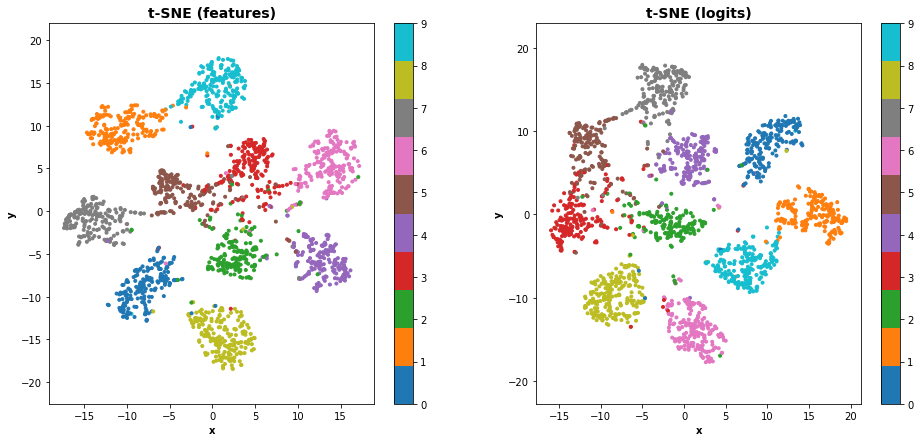

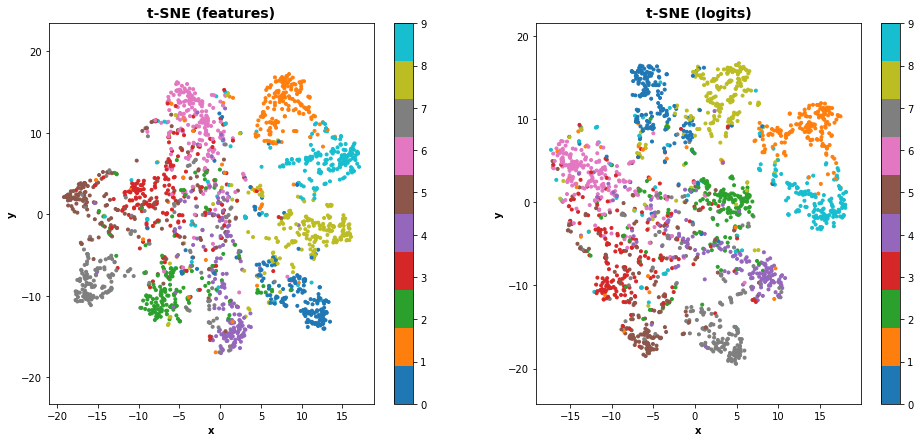

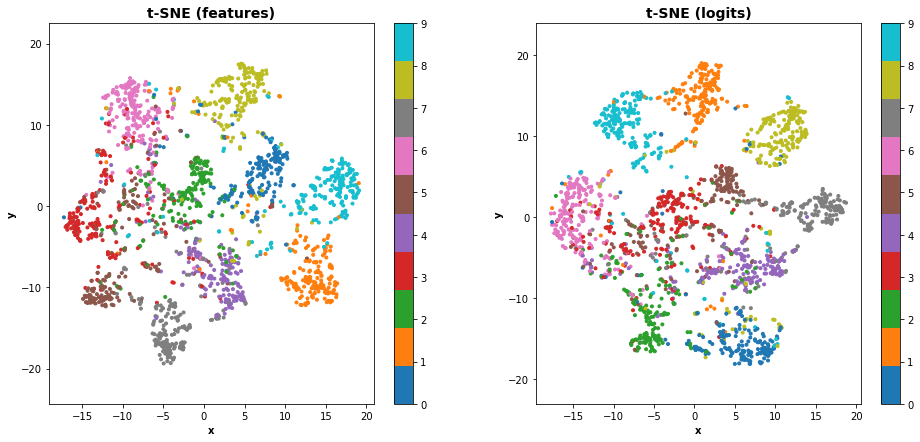

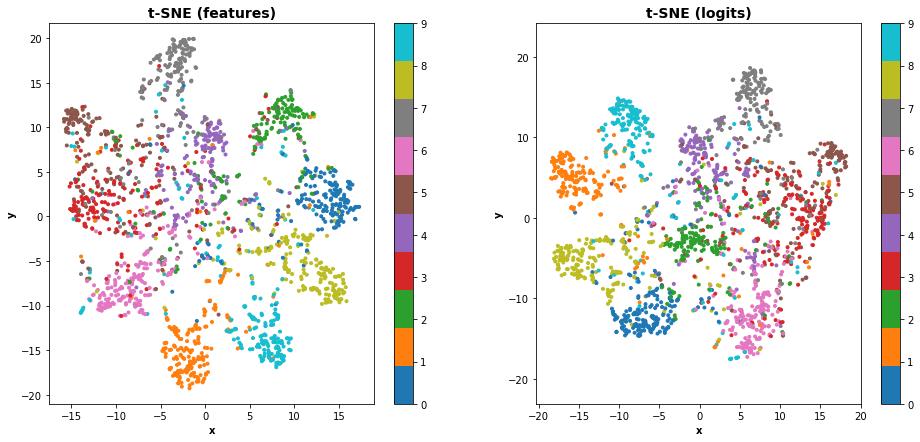

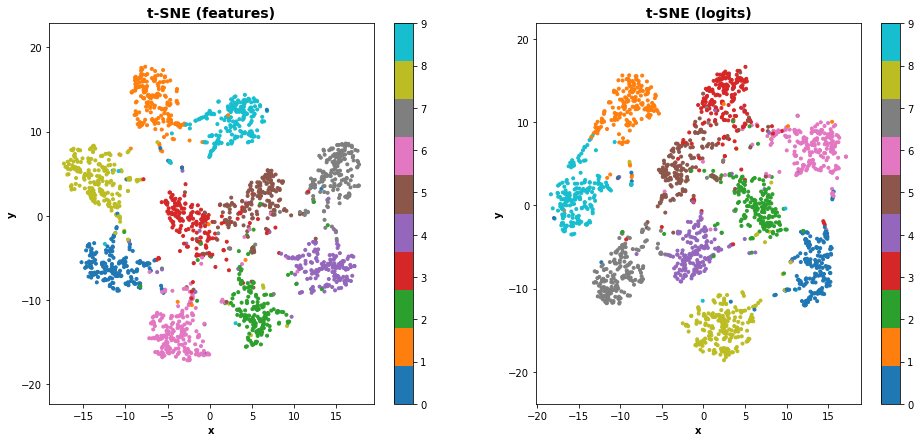

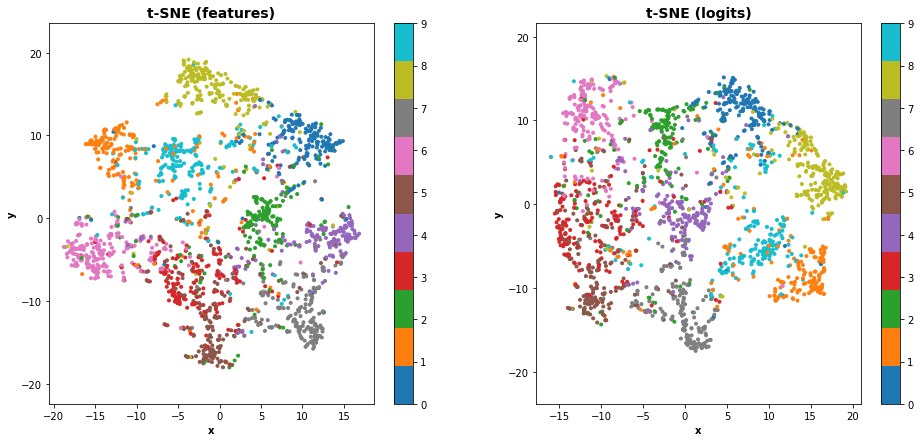

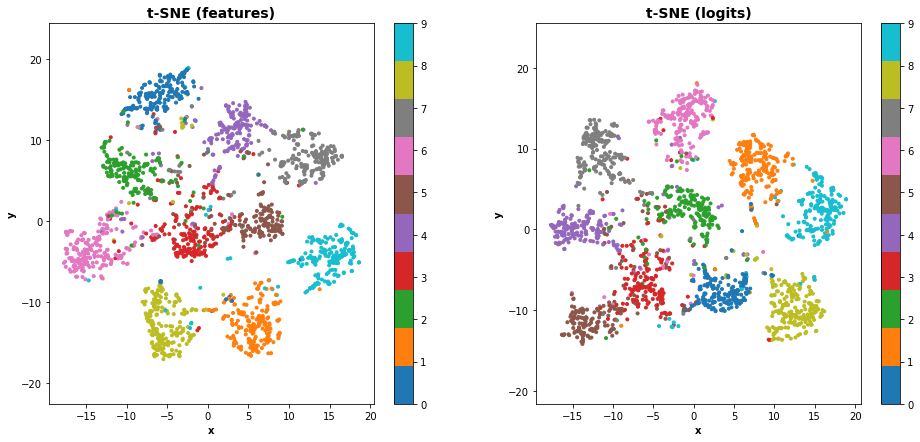

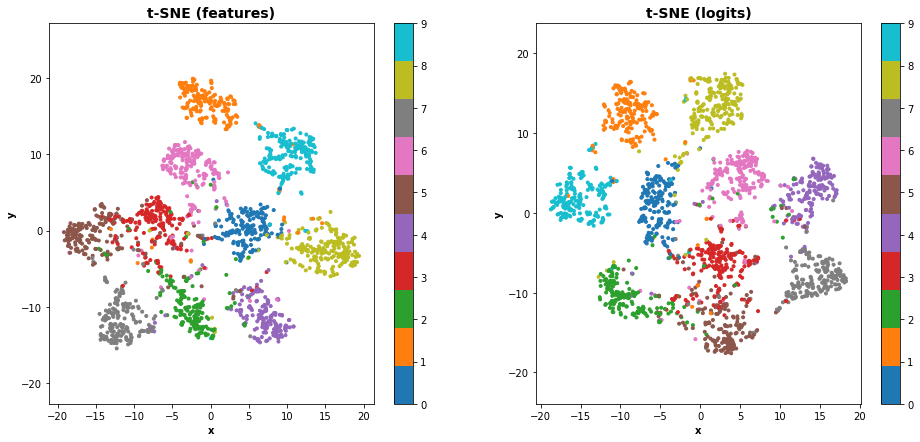

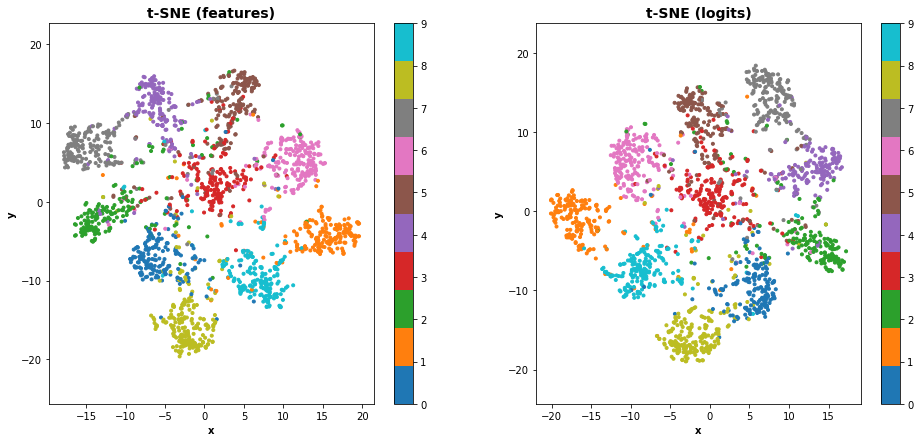

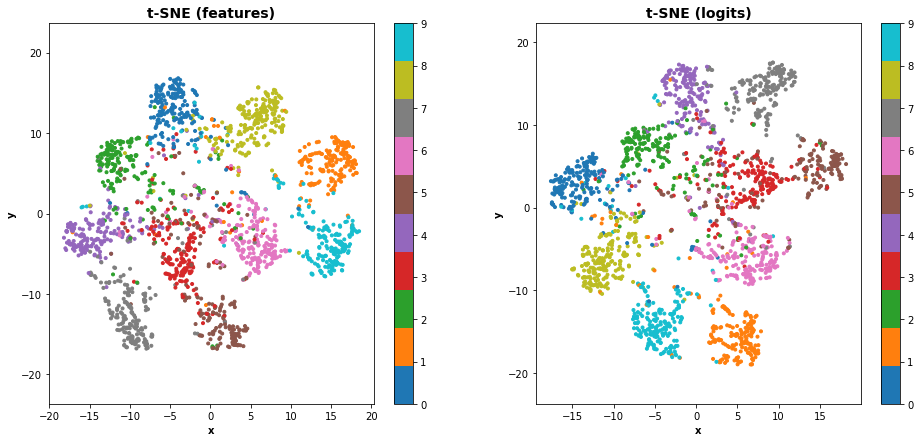

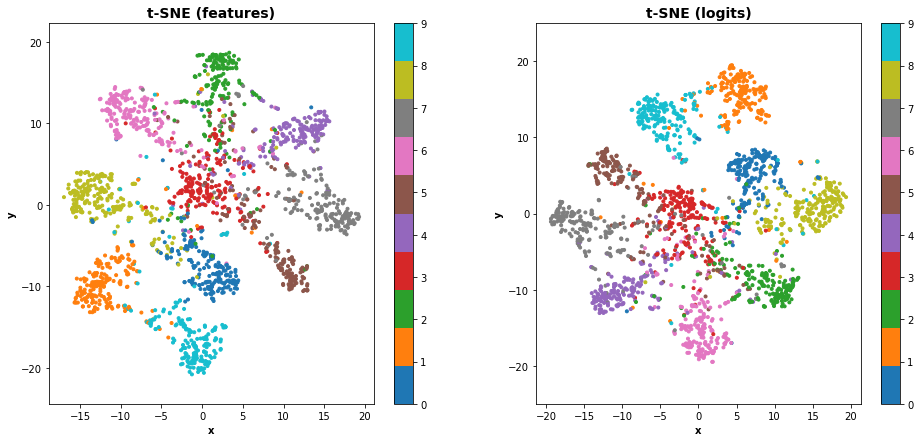

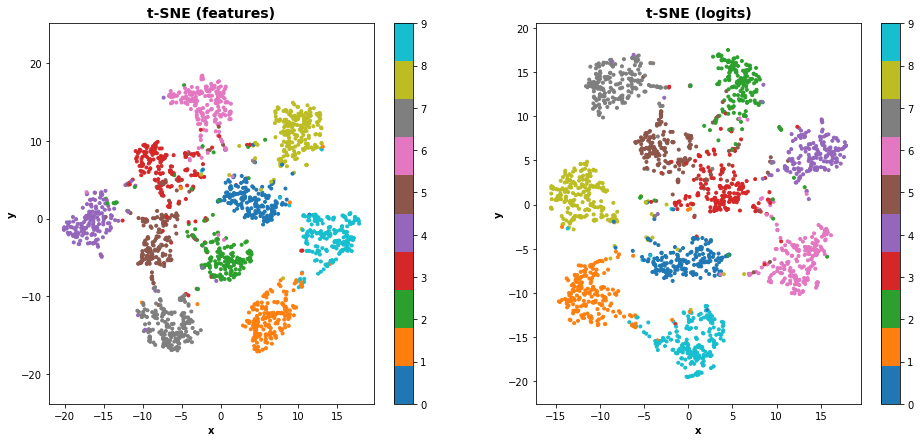

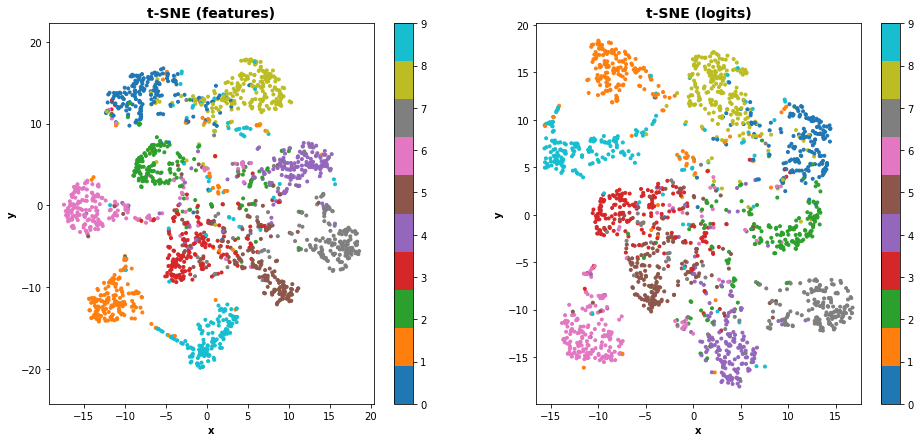

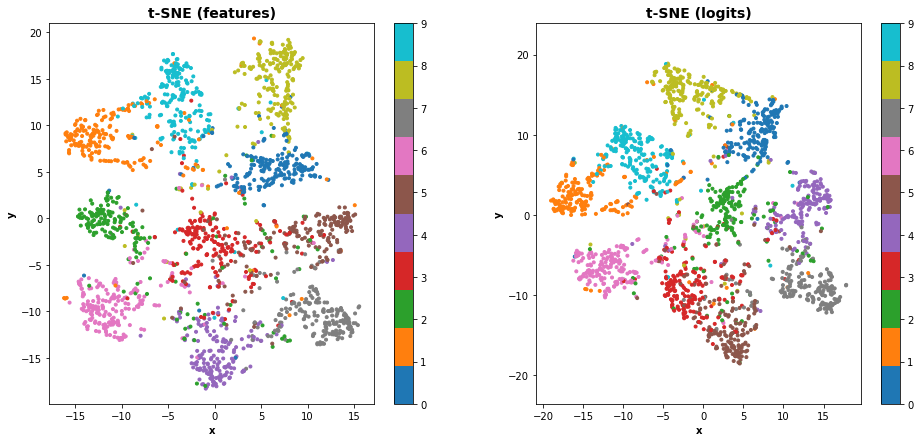

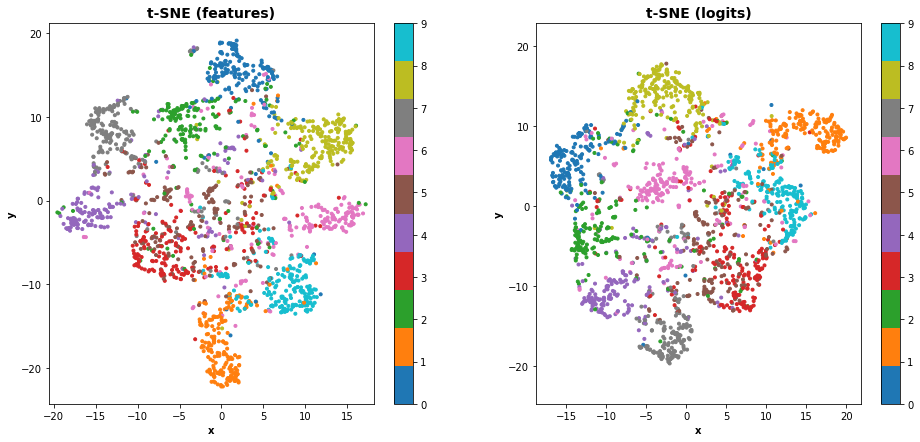

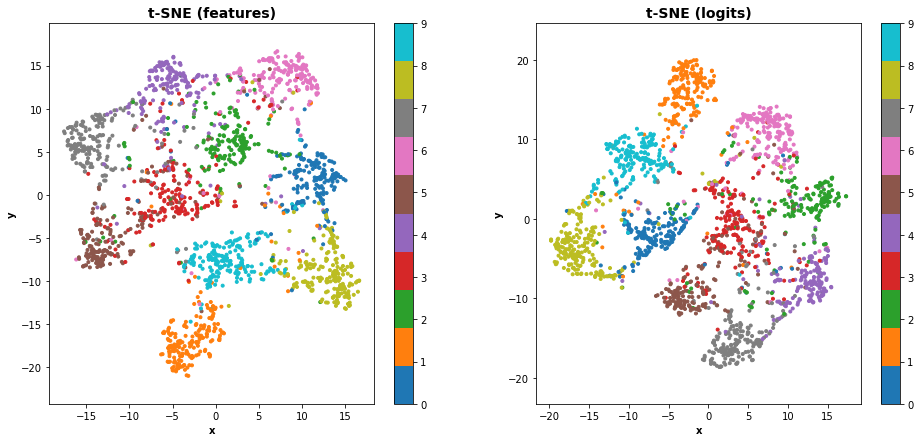

In [263]:
test_c_acc, test_c_table, test_c_cm = test_c(net, test_data, args, base_c_path)